### Determinando un FVG
Lo primero que debemos hacer es leer data.
Vamos a descargar data de BTCUSDT en el rango 2023-08-09 - 2023-08-11 (9 al 11 de Agosto de 2023) en la temporalidad M5

In [17]:
import pandas as pd
from lightweight_charts import Chart
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np

Este es un zip que tiene los datos de un solo dia 11 de Agosto en M5

In [18]:
zipfile_name = 'BTCUSDT-5m-2023-07.zip'
file_name = 'BTCUSDT-5m-2023-07.csv'
data_path = os.path.join('btc_fvg', zipfile_name)
# btc_fvg\BTCUSDT-5m-2023-08-11.zip

Leer el dataframe

In [19]:
def read_csv(data_path, file_name):
    """
    Function to read csv inside zip.
    Input path strings
    Output: Pandas Dataframe
    """ 
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        with zip_ref.open(file_name) as csv_file:
            # Lee el archivo CSV utilizando Pandas
            dataframe = pd.read_csv(csv_file)
            return dataframe


In [20]:
data = read_csv(data_path, file_name)
data.head()

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,1688169600000,30460.2,30485.7,30446.3,30482.5,799.801,1688169899999,2.436836e+07,8511,384.682,1.172102e+07,0
1,1688169900000,30482.4,30501.3,30467.7,30498.0,468.449,1688170199999,1.428181e+07,6918,232.469,7.087752e+06,0
2,1688170200000,30498.0,30507.4,30405.6,30438.6,1491.201,1688170499999,4.539821e+07,12631,566.777,1.725599e+07,0
3,1688170500000,30438.7,30478.9,30436.5,30471.3,788.212,1688170799999,2.400845e+07,9811,428.077,1.303770e+07,0
4,1688170800000,30471.3,30488.0,30452.8,30480.8,423.075,1688171099999,1.289331e+07,6376,237.315,7.232101e+06,0


Function to clean data to what i need


In [21]:

def prep_data(dataframe):
    # Eliminating irrelevant columns
    dataframe = dataframe[['open_time', 'open', 'high', 'low','close', 'volume']]
    dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')
    return dataframe

In [22]:
data_cleaned = prep_data(data)

C:\Users\eduar\AppData\Local\Temp\ipykernel_2356\2521195782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['open_time'] = pd.to_datetime(dataframe['open_time'],unit='ms')


Rename dataframe to match lightweight charts module requirement


In [23]:
data_cleaned = data_cleaned.rename(columns={"open_time": "time"})

# Setear el index como el timestamp de la
data_cleaned.set_index('time', inplace=True)

data_cleaned

,open,high,low,close,volume
time,,,,,
2023-07-01 00:00:00,30460.2,30485.7,30446.3,30482.5,799.801
2023-07-01 00:05:00,30482.4,30501.3,30467.7,30498.0,468.449
2023-07-01 00:10:00,30498.0,30507.4,30405.6,30438.6,1491.201
2023-07-01 00:15:00,30438.7,30478.9,30436.5,30471.3,788.212
2023-07-01 00:20:00,30471.3,30488.0,30452.8,30480.8,423.075
...,...,...,...,...,...
2023-07-31 23:35:00,29201.2,29207.4,29194.7,29201.5,254.461
2023-07-31 23:40:00,29201.5,29225.3,29199.8,29220.4,405.285
2023-07-31 23:45:00,29220.4,29229.6,29217.0,29229.6,541.594


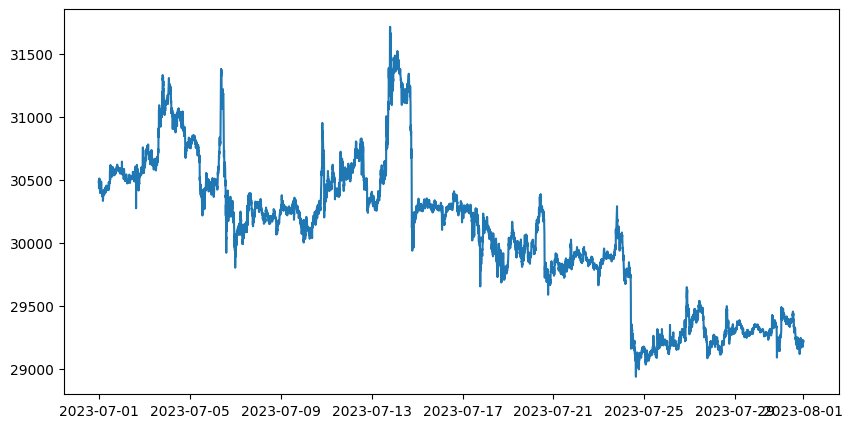

In [24]:
plt.figure(figsize=(10,5))
plt.plot(data_cleaned["close"])

### Optional Features
##### Resampling data to desired timeframe. 
Not used for this btc analysis.
In this example we wil resample to M15 candles.

In [25]:
data_resampled = data_cleaned.resample('15Min').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last','volume':'sum'})

data_resampled

,open,high,low,close,volume
time,,,,,
2023-07-01 00:00:00,30460.2,30507.4,30405.6,30438.6,2759.451
2023-07-01 00:15:00,30438.7,30524.7,30436.5,30504.0,1971.601
2023-07-01 00:30:00,30504.1,30527.2,30479.0,30503.5,2152.521
2023-07-01 00:45:00,30503.6,30503.6,30447.4,30459.1,1906.519
2023-07-01 01:00:00,30459.1,30475.7,30395.3,30463.9,2674.311
...,...,...,...,...,...
2023-07-31 22:45:00,29197.8,29202.3,29186.0,29199.6,853.390
2023-07-31 23:00:00,29199.5,29199.6,29176.2,29176.2,723.069
2023-07-31 23:15:00,29176.2,29207.4,29173.4,29184.3,1051.666


##### Select date ranges from dataframe with timestamp index
Select an specific date range from the entire dataset, asumming the dataframe is clean and have *time,open,high,low,close,volume* columns

In [26]:
# Select test start and finish
start_date_1 = '2023-07-20 00:00:00'
finish_date_1 = '2023-07-24 23:55:00'

# Apply mask on function
def select_daterange(dataframe, start_date, finish_date):
    selected = dataframe.loc[start_date:finish_date]
    return selected

data_selected = select_daterange(data_cleaned,start_date_1,finish_date_1)
data_selected


,open,high,low,close,volume
time,,,,,
2023-07-20 00:00:00,29895.5,29910.0,29880.0,29910.0,750.378
2023-07-20 00:05:00,29909.9,29916.1,29895.0,29895.0,594.052
2023-07-20 00:10:00,29895.1,29916.4,29890.8,29916.3,460.913
2023-07-20 00:15:00,29916.4,29916.4,29896.9,29912.0,251.142
2023-07-20 00:20:00,29912.0,29931.7,29903.7,29903.7,499.925
...,...,...,...,...,...
2023-07-24 23:35:00,29169.7,29179.3,29167.1,29176.1,158.448
2023-07-24 23:40:00,29176.1,29176.1,29159.4,29159.4,240.158
2023-07-24 23:45:00,29159.4,29165.0,29159.1,29162.2,203.160


#### Casper Silver Bullet Strategy
- 10-11 am NY time (UCT-4) =  14-15 UTC time

In [27]:
# Prueba para saber como seleccionar solamente las candles que pertenezcan a ese rango horario.
df_silverbullet = data_selected.between_time('14:00:00', '15:00:00')
df_silverbullet

,open,high,low,close,volume
time,,,,,
2023-07-20 14:00:00,30215.9,30230.3,30193.0,30222.3,1321.229
2023-07-20 14:05:00,30222.4,30222.4,30170.4,30181.4,1072.986
2023-07-20 14:10:00,30181.4,30210.0,30164.5,30190.0,856.470
2023-07-20 14:15:00,30189.9,30194.4,30100.0,30150.9,4706.957
2023-07-20 14:20:00,30151.0,30162.5,30088.1,30100.0,3267.071
...,...,...,...,...,...
2023-07-24 14:40:00,29069.0,29162.0,29060.3,29134.8,3138.219
2023-07-24 14:45:00,29134.7,29179.6,29105.0,29119.0,2509.275
2023-07-24 14:50:00,29119.0,29122.4,29074.3,29093.9,1534.929


Function to create our desired time ranges for start, which is 10am-11am NY time, traslated to UTC is 14:00-15:00.
It should iterate over all the days and select:
- Candles inside this timeframe.
- 1 candle prior to this timeframe, in order to be able to capture the first FVG.

In [28]:
# Cómo restar tiempo a un index timestamp en pandas.
data_selected.index[1] - pd.Timedelta(minutes=10)

Timestamp('2023-07-19 23:55:00')

### FVG Logic

##### Bullish FVG
    Price.Low (last) is greater than Price.High (2 candles ago) – This defines the lack of overlap between candle wicks
    Price.Close (1 candle ago) is greater than Price.Open (1 candle ago) by at least ‘x %’ – This defines the large buying pressure
    Price.Close (1 candle ago) is greater than Price.High  (2 candles ago) – This defines that the candle with the buying pressure closed above the high of the previous candle

- Definimos un gap minimo, porcentual. GAP = %
- EL LOW de la vela actual (last) es *mayor* que el HIGH de la vela 2 posiciones anterior.
- El CLOSE de la vela anterior (1 posicion anterior) es *mayor* que el OPEN de la vela 1 posicion anterior por al menos el GAP porcentual.
- El CLOSE de la vela 1 posicion anterior es *mayor* que el HIGH de la vela 2 posisciones anterior.


##### Bearish FVG
    Price.High (last) is less than Price.Low (2 candles ago) – This defines the lack of overlap between candle wicks
    Price.Close (1 candle ago) is less than Price.Open (1 candle ago) by at least ‘x %’ – This defines the large selling pressure
    Price.Close (1 candle ago) is less than Price.Low (2 candles ago) – This defines that the candle with the selling pressure closed below the low of the previous candle

- Definimos un gap minimo, porcentual. GAP = %
- El HIGH de la vela actual (last) es *menor* que el LOW de la vela 2 posiciones anterior.
- El CLOSE de la vela 1 posicion anterior es *menor* que el OPEN de la vela 1 posicion anterior por al menos el GAP porcentual.
- El CLOSE de la vela 1 posicion anterior es *menor* que el LOW de la vela 2 posiciones anterior.

In [29]:
# funcion para determinar FVG. SE dejará para después.

def fvg_detector(dataframe):
    # Define porcentual GAP
    percentual_gap = 1.00003
    
    # Obtain df lenght
    lenght = len(dataframe)
    
    # Entramos por cada fila
    for candle in range(lenght):
        #print(f"La vela {candle} tiene como open price {dataframe.iloc[candle]['open']}")
        # Define gap in USD:
        usd_gap = dataframe.iloc[candle-2]['high']*percentual_gap

        if candle >= 2:
            # Bulish FVG
            if dataframe.iloc[candle]['low'] > dataframe.iloc[candle-2]['high']\
            and dataframe.iloc[candle-1]['close'] > dataframe.iloc[candle-1]['open']\
            and dataframe.iloc[candle-1]['close'] > dataframe.iloc[candle-2]['high']:
            #and dataframe.iloc[candle]['close'] > dataframe.iloc[candle]['open']
                print(f"La vela {candle} generó un Bullish FVG en la vela {candle-1}, lowbarrier: {dataframe.iloc[candle-2]['high']}, high barrier: {dataframe.iloc[candle]['low']}")
            
            # Bearish FVG:
            if dataframe.iloc[candle]['high'] < dataframe.iloc[candle-2]['low']\
            and dataframe.iloc[candle-1]['close'] < dataframe.iloc[candle-1]['open']\
            and dataframe.iloc[candle-1]['close'] < dataframe.iloc[candle-2]['low']:
            #and dataframe.iloc[candle]['close'] < dataframe.iloc[candle]['open']
                print(f"La vela {candle} generó un Bearish FVG en la vela {candle-1}, lowbarrier: {dataframe.iloc[candle]['high']}, high barrier: {dataframe.iloc[candle-2]['low']}")

    return
    



fvg_detector(data_cleaned)

La vela 6 generó un Bullish FVG en la vela 5, lowbarrier: 30488.0, high barrier: 30493.5
La vela 10 generó un Bearish FVG en la vela 9, lowbarrier: 30480.0, high barrier: 30502.2
La vela 13 generó un Bearish FVG en la vela 12, lowbarrier: 30446.0, high barrier: 30450.0
La vela 19 generó un Bullish FVG en la vela 18, lowbarrier: 30425.0, high barrier: 30430.7
La vela 30 generó un Bullish FVG en la vela 29, lowbarrier: 30465.0, high barrier: 30485.3
La vela 32 generó un Bearish FVG en la vela 31, lowbarrier: 30482.6, high barrier: 30485.3
La vela 34 generó un Bearish FVG en la vela 33, lowbarrier: 30424.6, high barrier: 30456.3
La vela 48 generó un Bullish FVG en la vela 47, lowbarrier: 30388.1, high barrier: 30391.2
La vela 51 generó un Bearish FVG en la vela 50, lowbarrier: 30382.0, high barrier: 30389.9
La vela 55 generó un Bullish FVG en la vela 54, lowbarrier: 30349.3, high barrier: 30350.4
La vela 56 generó un Bullish FVG en la vela 55, lowbarrier: 30353.8, high barrier: 30362.4
La

### Casper Silver Bullet Strategy:
Rules:
- Entry on first FVG created between 14:00 and 15:00 UTC (NY 10:00-11:00 am session) only weekdays.
- 2R fixed Risk to reward
- Close position at TP or at 20:00 UTC (NY 16:00)
- If price reach TP before entry, cancel order.
- FVG can be formed using previous candle as first of the three candles forming FVG.

In [64]:
# Original function created by me.
def casper_fvg(dataframe):
        
    #Silve Bullet parameters:
    sb_start = pd.Timestamp("14:00:00").time()
    sb_end = pd.Timestamp("15:00:00").time()
    executed_today = False

    for time, candle in dataframe.iterrows():
               
        position_open = False

        # Condition to iterate only on weekdays between 14-15 UTC:
        if sb_start <= time.time() <= sb_end and time.weekday()<5:

            # Bullish FVG
            if dataframe['low'].loc[time] > dataframe['high'].shift(2).loc[time]\
            and dataframe['close'].shift(1).loc[time] > dataframe['open'].shift(1).loc[time]\
            and dataframe['close'].shift(1).loc[time] > dataframe['high'].shift(2).loc[time]:
                print(f"La vela {time} generó un Bullish FVG ,lowbarrier: {dataframe['high'].shift(2).loc[time]}, high barrier: {dataframe['low'].loc[time]}")
                executed_today = True
                

            # Bearish FVG:
            if dataframe['high'].loc[time] < dataframe['low'].shift(2).loc[time]\
            and dataframe['close'].shift(1).loc[time] < dataframe['open'].shift(1).loc[time]\
            and dataframe['close'].shift(1).loc[time] < dataframe['low'].shift(2).loc[time]: 
                print(f"La vela {time} generó un Bearish FVG, lowbarrier: {dataframe['high'].loc[time]}, high barrier: {dataframe['low'].shift(2).loc[time]}")
                executed_today = True
                
        
# No se por que me salen dos FVG por dia a veces, resolver el bug mañana.
casper_fvg(data_cleaned)

La vela 2023-07-03 14:05:00 generó un Bullish FVG ,lowbarrier: 30647.5, high barrier: 30664.5
La vela 2023-07-03 15:00:00 generó un Bullish FVG ,lowbarrier: 30725.0, high barrier: 30729.8
La vela 2023-07-04 14:45:00 generó un Bearish FVG, lowbarrier: 30994.3, high barrier: 31000.8
La vela 2023-07-05 14:20:00 generó un Bullish FVG ,lowbarrier: 30365.3, high barrier: 30369.2
La vela 2023-07-06 14:45:00 generó un Bullish FVG ,lowbarrier: 30047.6, high barrier: 30049.2
La vela 2023-07-07 14:15:00 generó un Bearish FVG, lowbarrier: 30327.5, high barrier: 30333.4
La vela 2023-07-07 14:45:00 generó un Bullish FVG ,lowbarrier: 30320.0, high barrier: 30321.8
La vela 2023-07-10 14:20:00 generó un Bullish FVG ,lowbarrier: 30269.4, high barrier: 30272.0
La vela 2023-07-10 14:40:00 generó un Bearish FVG, lowbarrier: 30221.6, high barrier: 30257.9
La vela 2023-07-10 14:50:00 generó un Bullish FVG ,lowbarrier: 30221.6, high barrier: 30257.1
La vela 2023-07-10 14:55:00 generó un Bullish FVG ,lowbarrie

In [ ]:
for date in data_cleaned.groupby(data_cleaned.index.date):
    print (date)

In [65]:
def casper_fvg(dataframe):
    # Silver Bullet session parameters:
    sb_start = pd.Timestamp("14:00:00").time()
    sb_end = pd.Timestamp("15:00:00").time()

    # Firs loop to iterate over each single days
    for date, group in dataframe.groupby(dataframe.index.date):
        executed_today = False

        # Second loop to iterate over all candles on a single day
        for time, candle in group.iterrows():
            # Check if already detected today
            if executed_today:
                break

            # Condition to iterate only on weekdays between 14-15 UTC
            if sb_start <= time.time() <= sb_end and time.weekday() < 5:

                # Bullish FVG
                if candle['low'] > group['high'].shift(2).loc[time] \
                and group['close'].shift(1).loc[time] > group['open'].shift(1).loc[time] \
                and group['close'].shift(1).loc[time] > group['high'].shift(2).loc[time]:
                    
                    print(f"La vela {time} generó un Bullish FVG, lowbarrier: {group['high'].shift(2).loc[time]}, high barrier: {candle['low']}")
                    executed_today = True

                # Bearish FVG
                if candle['high'] < group['low'].shift(2).loc[time] \
                and group['close'].shift(1).loc[time] < group['open'].shift(1).loc[time] \
                and group['close'].shift(1).loc[time] < group['low'].shift(2).loc[time]:
                    
                    print(f"La vela {time} generó un Bearish FVG, lowbarrier: {candle['high']}, high barrier: {group['low'].shift(2).loc[time]}")
                    executed_today = True


casper_fvg(data_cleaned)

La vela 2023-07-03 14:05:00 generó un Bullish FVG, lowbarrier: 30647.5, high barrier: 30664.5
La vela 2023-07-04 14:45:00 generó un Bearish FVG, lowbarrier: 30994.3, high barrier: 31000.8
La vela 2023-07-05 14:20:00 generó un Bullish FVG, lowbarrier: 30365.3, high barrier: 30369.2
La vela 2023-07-06 14:45:00 generó un Bullish FVG, lowbarrier: 30047.6, high barrier: 30049.2
La vela 2023-07-07 14:15:00 generó un Bearish FVG, lowbarrier: 30327.5, high barrier: 30333.4
La vela 2023-07-10 14:20:00 generó un Bullish FVG, lowbarrier: 30269.4, high barrier: 30272.0
La vela 2023-07-11 14:00:00 generó un Bullish FVG, lowbarrier: 30411.7, high barrier: 30415.5
La vela 2023-07-12 14:00:00 generó un Bullish FVG, lowbarrier: 30612.3, high barrier: 30639.2
La vela 2023-07-13 14:05:00 generó un Bearish FVG, lowbarrier: 30570.0, high barrier: 30619.2
La vela 2023-07-14 14:05:00 generó un Bearish FVG, lowbarrier: 31230.2, high barrier: 31241.6
La vela 2023-07-17 14:30:00 generó un Bearish FVG, lowbarrie

In [59]:
def casper_fvg(dataframe):
    # Silver Bullet session parameters:


    # Firs loop to iterate over each single days
    for date, group in dataframe.groupby(dataframe.index.date):
        executed_today = False
        #print (date)
        #print (group)
        print("Grupo 1")
        for time, candle in group.iterrows():
            print (time)
            print(candle)

casper_fvg(data_cleaned)

Grupo 1
2023-07-01 00:00:00
open      30460.200
high      30485.700
low       30446.300
close     30482.500
volume      799.801
Name: 2023-07-01 00:00:00, dtype: float64
2023-07-01 00:05:00
open      30482.400
high      30501.300
low       30467.700
close     30498.000
volume      468.449
Name: 2023-07-01 00:05:00, dtype: float64
2023-07-01 00:10:00
open      30498.000
high      30507.400
low       30405.600
close     30438.600
volume     1491.201
Name: 2023-07-01 00:10:00, dtype: float64
2023-07-01 00:15:00
open      30438.700
high      30478.900
low       30436.500
close     30471.300
volume      788.212
Name: 2023-07-01 00:15:00, dtype: float64
2023-07-01 00:20:00
open      30471.300
high      30488.000
low       30452.800
close     30480.800
volume      423.075
Name: 2023-07-01 00:20:00, dtype: float64
2023-07-01 00:25:00
open      30480.800
high      30524.700
low       30468.000
close     30504.000
volume      760.314
Name: 2023-07-01 00:25:00, dtype: float64
2023-07-01 00:30:00
